## Importing packages and data

In [1]:
## Importing packages and data
# Importing libraries
import pandas as pd
import numpy as np

# Configure matplotlib for inline plotting in Jupyter
%matplotlib inline
import matplotlib.pyplot as plt
plt.ion()  # Enable interactive mode
from matplotlib import colors
import seaborn as sns
import matplotlib
#matplotlib.use('inline')  # or 'Qt5Agg' depending on your system
import json
import os
from pathlib import Path
import copy
import base64

from subprocess import Popen, PIPE, STDOUT
from glob import glob

import langchain  # Main LangChain import
from langchain_openai import ChatOpenAI  # To work with OpenAI
from langchain_anthropic import ChatAnthropic
from langchain_core.prompts import ChatPromptTemplate
#from langchain_ollama.llms import OllamaLLM
# from langchain_google_genai import ChatGoogleGenerativeAI # To work with Gemini (optional)
from langchain_core.output_parsers import JsonOutputParser  # To help with structured output
from langchain_core.prompts import PromptTemplate  # To help create our prompt
from langchain_core.pydantic_v1 import BaseModel, Field  # To help with defining what output structure we want
from pydantic import BaseModel
from langchain_core.tools import tool

from typing import List, Tuple

from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver

from langchain_core.prompts import PromptTemplate
from langchain_core.messages import AIMessage
from langchain.load.dump import dumps
from langchain_core.messages import HumanMessage

from dotenv import load_dotenv

import logging
import sys

import ast

C:\Users\Soren\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\interactiveshell.py:3508: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
# ==========================
# Configure Logging
# ==========================

# Create a logger
logger = logging.getLogger('ReWOO_LangGraph')
logger.setLevel(logging.DEBUG)

# Clear any existing handlers attached to the logger
if logger.hasHandlers():
    logger.handlers.clear()

# Create handlers
c_handler = logging.StreamHandler(sys.stdout)
f_handler = logging.FileHandler('rewoolanggraph.log', mode='w')

c_handler.setLevel(logging.INFO)
f_handler.setLevel(logging.DEBUG)

# Create formatters and add them to handlers
c_format = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
f_format = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
c_handler.setFormatter(c_format)
f_handler.setFormatter(f_format)

# Add handlers to the logger
logger.addHandler(c_handler)
logger.addHandler(f_handler)


In [3]:
# ==========================
# Function to load JSON files
# ==========================

def load_json(filepath):
    with open(filepath, 'r') as file:
        return json.load(file)

In [4]:
# ==========================
# Loading Files
# ==========================

base_path = 'data/challenges/'

# Subset of challenges for testing
subset_ids_challenges = load_json(base_path + '28_8x10_challenges.json')
subset_ids_evaluation = load_json(base_path + '28_15x15_evaluation.json')

# Load evaluation dataset
evaluation_challenges = load_json(base_path + 'arc-agi_evaluation_challenges.json')
evaluation_solutions = load_json(base_path + 'arc-agi_evaluation_solutions.json')

# load training dataset
training_challenges = load_json(base_path + 'arc-agi_training_challenges.json')
training_solutions = load_json(base_path + 'arc-agi_training_solutions.json')

# Filter training challenges and solutions to only include the subset IDs
training_challenges = {k: v for k, v in training_challenges.items() if k in subset_ids_challenges}
training_solutions = {k: v for k, v in training_solutions.items() if k in subset_ids_challenges}

# filter evaluation challenges and solutions to only include the subset IDs
evaluation_challenges = {k: v for k, v in evaluation_challenges.items() if k in subset_ids_evaluation}
evaluation_solutions = {k: v for k, v in evaluation_solutions.items() if k in subset_ids_evaluation}

test_challenges = load_json(base_path + 'arc-agi_test_challenges.json')



task_sets = {
    'training': {
        'challenges': training_challenges,
        'solutions': training_solutions,
    },
    'evaluation': {
        'challenges': evaluation_challenges,
        'solutions': evaluation_solutions,
    }
}

In [5]:
# ==========================
# Function to load tasks from a pre-loaded task set
# ==========================

def load_tasks_from_file(task_set):
    """
    Loads the tasks from the pre-loaded JSON data and returns the challenges and solutions tasks.
    """
    challenges = task_set['challenges']
    solutions = task_set['solutions']

    return challenges, solutions

In [6]:
# ==========================
# Print Dataset Information
# ==========================

print(f'Number of filtered training challenges = {len(training_challenges)}')
print(f'Number of filtered training solutions = {len(training_solutions)}')

# Loading tasks from the 'training' task set
challenges, solutions = load_tasks_from_file(task_set=task_sets['training'])
print(json.dumps(challenges['0520fde7'], indent=2))  # Accessing a specific challenge

Number of filtered training challenges = 28
Number of filtered training solutions = 28
{
  "test": [
    {
      "input": [
        [
          1,
          0,
          1,
          5,
          1,
          0,
          1
        ],
        [
          0,
          1,
          0,
          5,
          1,
          0,
          1
        ],
        [
          1,
          0,
          1,
          5,
          0,
          1,
          0
        ]
      ]
    }
  ],
  "train": [
    {
      "input": [
        [
          1,
          0,
          0,
          5,
          0,
          1,
          0
        ],
        [
          0,
          1,
          0,
          5,
          1,
          1,
          1
        ],
        [
          1,
          0,
          0,
          5,
          0,
          0,
          0
        ]
      ],
      "output": [
        [
          0,
          0,
          0
        ],
        [
          0,
          2,
          0
        ],
        [
  

#### initializing LLM client to use

In [ ]:

# Load environment variables from .env file
load_dotenv('api.env')

# Get the OpenAI API key from environment variables
openai_api_key = os.getenv('OPENAI_API_KEY')
anthropic_api_key =os.getenv('ANTHROPIC_API_KEY')

# MORE EXPENSIVE MODELS
llm_openai = ChatOpenAI(model='gpt-4o', openai_api_key=openai_api_key, max_tokens=3000)
#llm_anthropic = ChatAnthropic(model='claude-3-5-sonnet-20241022', anthropic_api_key=anthropic_api_key, max_tokens=3000)

# CHEAPER MODELS
#llm_openai = ChatOpenAI(model='gpt-4o-mini', openai_api_key=openai_api_key, max_tokens=3000)
#llm_anthropic = ChatAnthropic(model='claude-3-haiku-20240307', anthropic_api_key=anthropic_api_key, max_tokens=3000)

# LOCAL MODELS USING OLLAMA
#llm_local = OllamaLLM(model= "llama3.2")

### Function for visualizing the tasks

In [8]:
# ==========================
# Functions to visualize tasks
# ==========================

cmap = colors.ListedColormap(
   ['#000000', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00',
    '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25', '#FFFFFF'])
norm = colors.Normalize(vmin=0, vmax=10)
# print(norm)

def plot_one(ax, i, task, train_or_test, input_or_output):
    # Check if input_or_output is 'solution' or 'predicted_solution'
    if input_or_output == 'solution':
        input_matrix = task[train_or_test][i]['output']  # Assuming this is the ground truth solution
    elif input_or_output == 'predicted_solution':
        input_matrix = task.get('prediction', [])[i]  # Access the predicted solution from task
    else:
        input_matrix = task[train_or_test][i][input_or_output]

    ax.imshow(input_matrix, cmap=cmap, norm=norm)
    ax.grid(True, which='both', color='lightgrey', linewidth=0.5)
    plt.setp(plt.gcf().get_axes(), xticklabels=[], yticklabels=[])
    ax.set_xticks([x - 0.5 for x in range(1 + len(input_matrix[0]))])     
    ax.set_yticks([x - 0.5 for x in range(1 + len(input_matrix))])
    ax.set_title(f"{train_or_test} {input_or_output}")
    return None

   
def plot_eval(task, text, test_input, predicted_solution, actual_solution):
    """
    Plots a single row with three columns: input, predicted solution, and actual solution.
    """
    try:
        # Convert inputs to numpy arrays if they aren't already
        test_input = np.array(test_input)
        predicted_solution = np.array(predicted_solution)
        actual_solution = np.array(actual_solution)
        
        plt.close('all')  # Close any existing plots
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle(f'{text}', fontsize=16, fontweight='bold')

        # Plot evaluation input
        axs[0].imshow(test_input, cmap=cmap, norm=norm)
        axs[0].set_title('Evaluation Input')
        axs[0].grid(True, color='lightgrey', linewidth=0.5)
        axs[0].set_xticks([x - 0.5 for x in range(1 + len(test_input[0]))]) 
        axs[0].set_yticks([x - 0.5 for x in range(1 + len(test_input))])

        # Plot model's predicted solution
        axs[1].imshow(predicted_solution, cmap=cmap, norm=norm)
        axs[1].set_title('Model Prediction')
        axs[1].grid(True, color='lightgrey', linewidth=0.5)
        axs[1].set_xticks([x - 0.5 for x in range(1 + len(predicted_solution[0]))]) 
        axs[1].set_yticks([x - 0.5 for x in range(1 + len(predicted_solution))])

        # Plot actual solution
        axs[2].imshow(actual_solution, cmap=cmap, norm=norm)
        axs[2].set_title('Actual Solution')
        axs[2].grid(True, color='lightgrey', linewidth=0.5)
        axs[2].set_xticks([x - 0.5 for x in range(1 + len(actual_solution[0]))]) 
        axs[2].set_yticks([x - 0.5 for x in range(1 + len(actual_solution))])

        # Add value annotations to each cell
        for ax, data in zip(axs, [test_input, predicted_solution, actual_solution]):
            for i in range(len(data)):
                for j in range(len(data[0])):
                    ax.text(j, i, str(data[i][j]), 
                           ha='center', va='center',
                           color='white' if data[i][j] in [0, 1, 9] else 'black')

        plt.tight_layout()
        plt.show()
        plt.close()  # Close the plot after showing it
        
    except Exception as e:
        logger.error(f"Error in plot_eval: {str(e)}")
        plt.close('all')  # Clean up any partial plots
 
def plot_task(task1, text):    
    num_train = len(task1['train'])
    w=num_train
    fig, axs  = plt.subplots(2, w, figsize=(3*w ,3*2))
    plt.suptitle(f'{text}:', fontsize=20, fontweight='bold', y=1)

    for j in range(num_train):     
        plot_one(axs[0, j], j,task1,'train', 'input')
        plot_one(axs[1, j], j,task1,'train', 'output')  
    
    fig.patch.set_linewidth(5)
    fig.patch.set_edgecolor('black') 
    fig.patch.set_facecolor('#dddddd')
    plt.tight_layout()
    # plt.show()
    return plt    
    
def openai_encode_image_base64(plt):
    import io
    plt_stringIObytes = io.BytesIO()
    plt.savefig(plt_stringIObytes, format='png')
    plt_stringIObytes.seek(0)
    base64_image = base64.b64encode(plt_stringIObytes.read()).decode('utf-8')
    return {
      "type": "image_url",
      "image_url": {
        "url": f"data:image/jpeg;base64,{base64_image}"
      }
    }

## Trying to make MVP product which is just regular openai model trying to predict 

In [9]:
def json_task_to_string(challenge_tasks: dict, task_id: str, test_input_index: int) -> str:
    """
    Convert task to string format with proper test input handling
    """
    json_task = challenge_tasks[task_id]
    final_output = []

    # Add training examples (this part is working correctly)
    final_output.append("Training Examples")
    for i, task in enumerate(json_task['train']):
        final_output.append(f"\nExample {i + 1}: Input")
        final_output.append("[")
        for row in task['input']:
            final_output.append(f"{row},")
        final_output.append("]")

        final_output.append(f"\nExample {i + 1}: Output")
        final_output.append("[")
        for row in task['output']:
            final_output.append(f"{row},")
        final_output.append("]")

    # Fix test input handling
    final_output.append("\nTest")
    final_output.append("[")
    
    # Get the correct test input
    test_input = json_task['test'][test_input_index]['input']
    
    # Create a deep copy to prevent modifications
    test_input = copy.deepcopy(test_input)
    
    # Format test input properly
    for i, row in enumerate(test_input):
        if i < len(test_input) - 1:
            final_output.append(f"{row},")
        else:
            final_output.append(f"{row}")  # No comma for last row
    final_output.append("]")

    final_output.append("\nYour Response:")
    
    # Add validation before returning
    result = "\n".join(final_output)
    
    # Log the test input for verification
    logger.debug(f"Original test input: {json_task['test'][test_input_index]['input']}")
    logger.debug(f"Formatted test input: {test_input}")
    
    return result

In [10]:
# an example of how the function works
task_string = json_task_to_string(challenges, '0520fde7', 0)
print (task_string)

Training Examples

Example 1: Input
[
[1, 0, 0, 5, 0, 1, 0],
[0, 1, 0, 5, 1, 1, 1],
[1, 0, 0, 5, 0, 0, 0],
]

Example 1: Output
[
[0, 0, 0],
[0, 2, 0],
[0, 0, 0],
]

Example 2: Input
[
[1, 1, 0, 5, 0, 1, 0],
[0, 0, 1, 5, 1, 1, 1],
[1, 1, 0, 5, 0, 1, 0],
]

Example 2: Output
[
[0, 2, 0],
[0, 0, 2],
[0, 2, 0],
]

Example 3: Input
[
[0, 0, 1, 5, 0, 0, 0],
[1, 1, 0, 5, 1, 0, 1],
[0, 1, 1, 5, 1, 0, 1],
]

Example 3: Output
[
[0, 0, 0],
[2, 0, 0],
[0, 0, 2],
]

Test
[
[1, 0, 1, 5, 1, 0, 1],
[0, 1, 0, 5, 1, 0, 1],
[1, 0, 1, 5, 0, 1, 0]
]

Your Response:


In [11]:
# Using a json output parser to parse the output, since LLMs aren't perfect at generating valid json
# Defining a prediction as a list of lists
class ARCPrediction(BaseModel):
    prediction: List[List] = Field(..., description="A prediction for a task")

## Setting up langgraph for mUlTiaGenTiC sYstEM

In [12]:
# Setting up the state for the graph
class State(TypedDict):
    messages: Annotated[list, add_messages]
    patterns: Annotated[list, add_messages]
    code: str
    prediction: List[List]
    task_string: str
    task_data: dict
    test_input_index: int
    predicted_grid_size: str  # Add this line



# Creating tools for the agents to manipulate the gridz

In [13]:
import copy

def get_size(grid):
    ''' Returns the size of the grid in 2 axes '''
    return (len(grid), len(grid[0]))

def get_middle(coords):
    ''' Returns the middle (centroid) of the coordinates '''
    x_sum, y_sum = 0, 0
    for (x, y) in coords:
        x_sum += int(x)
        y_sum += int(y)
    return (int(x_sum / len(coords) + 0.5), int(y_sum / len(coords) + 0.5))

def get_anchor(coords):
    ''' Returns the top-left and bottom-right anchors of the shape '''
    min_x, min_y = float('inf'), float('inf')
    max_x, max_y = float('-inf'), float('-inf')
    for (x, y) in coords:
        min_x = min(x, min_x)
        min_y = min(y, min_y)
        max_x = max(x, max_x)
        max_y = max(y, max_y)
    return (min_x, min_y), (max_x, max_y)

def array_to_string(grid):
    ''' Converts numerical grid to string representation '''
    # If grid is already in string form, just return it
    if isinstance(grid[0][0], str):
        return grid

    mapping = {0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd',
               5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j'}
    newgrid = [[mapping.get(cell, '.') for cell in row] for row in grid]
    return newgrid

def string_to_array(grid):
    ''' Converts string grid to numerical representation '''
    # If grid is already in integer form, just return it
    if isinstance(grid[0][0], int):
        return grid

    mapping = {'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4,
               'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10}
    newgrid = [[mapping.get(cell, 0) for cell in row] for row in grid]
    return newgrid

def get_pixel_coords(grid):
    ''' Gets the coordinates of all the pixel values '''
    pixel_coord = {}
    for row in range(len(grid)):
        for col in range(len(grid[0])):
            value = grid[row][col]
            if value != 0:  # We assume '0' represents empty space
                if value in pixel_coord:
                    pixel_coord[value].append((row, col))
                else:
                    pixel_coord[value] = [(row, col)]
    return dict(sorted(pixel_coord.items(), key=lambda x: -len(x[1])))

def obj_to_coords(obj):
    ''' Converts an object with a grid and top-left coordinate to a list of absolute coordinates '''
    coords = []
    x, y = obj['tl']
    height, width = len(obj['grid']), len(obj['grid'][0])
    for i in range(height):
        for j in range(width):
            if obj['grid'][i][j] != 0:
                coords.append((x + i, y + j))
    return coords

def create_object(grid, coords):
    ''' Create an object based on the existing grid and the coordinates of it '''
    (min_x, min_y), (max_x, max_y) = get_anchor(coords)
    newgrid = [[0 for _ in range(max_y - min_y + 1)] for _ in range(max_x - min_x + 1)]
    for (x, y) in coords:
        if grid[x][y] == 0:
            newgrid[x - min_x][y - min_y] = -1  # Indicate empty spot with -1
        else:
            newgrid[x - min_x][y - min_y] = grid[x][y]
    return {'tl': (min_x, min_y), 'grid': newgrid}

def get_objects(grid, diag=False, multicolor=False, by_row=False, by_col=False, by_color=False, more_info=True):
    '''
    Identifies and extracts distinct objects from a grid.
    
    Parameters:
    - grid (list of list of int): The input grid where each cell contains an integer value representing a color or empty space.
    - diag (bool, optional): If True, considers diagonal connections when identifying objects. Defaults to False.
    - multicolor (bool, optional): If True, allows objects to consist of multiple colors. Defaults to False.
    - by_row (bool, optional): If True, splits objects by rows. Defaults to False.
    - by_col (bool, optional): If True, splits objects by columns. Defaults to False.
    - by_color (bool, optional): If True, groups each color as a separate object. Defaults to False.
    - more_info (bool, optional): If True, includes additional details about each object. Defaults to True.
    
    Returns:
    - list of dict: A list of dictionaries, each representing an object with:
        - 'tl' (tuple of int): Top-left coordinate of the object.
        - 'grid' (list of list of int): 2D grid representing the object's shape and colors.
        - 'size' (tuple of int): Dimensions of the object's grid (rows, columns).
        - 'cell_count' (int): Number of cells that make up the object.
        - 'shape' (list of list of int): Binary representation of the object's shape (1 for filled, 0 for empty).
    '''
    rows = len(grid)
    cols = len(grid[0])
    visited = set()
    objects = []
    missing_color = False
    
    # Check whether there is a missing color (using '10' to denote missing color)
    for each in grid:
        for cell in each:
            if cell == 10:
                missing_color = True

    def is_valid(grid, row, col, value):
        # multicolor can return any cell as long as it is not visited and not a blank
        if multicolor:
            return (0 <= row < rows and 0 <= col < cols and 
                    (row, col) not in visited and grid[row][col] != 0 and grid[row][col] != -1)
        else:
            return (0 <= row < rows and 0 <= col < cols and 
                    (row, col) not in visited and grid[row][col] == value)

    def dfs(grid, row, col, value):
        if is_valid(grid, row, col, value):
            visited.add((row, col))
            object_coords.add((row, col))
            
            if not by_row:
                dfs(grid, row - 1, col, value)  # up
                dfs(grid, row + 1, col, value)  # down
            if not by_col:
                dfs(grid, row, col - 1, value)  # left
                dfs(grid, row, col + 1, value)  # right
            if not by_row and not by_col and diag:
                dfs(grid, row - 1, col - 1, value)  # top-left diagonal
                dfs(grid, row - 1, col + 1, value)  # top-right diagonal
                dfs(grid, row + 1, col - 1, value)  # bottom-left diagonal
                dfs(grid, row + 1, col + 1, value)  # bottom-right diagonal

    # If by_color, we don't need to do dfs
    if by_color:
        pixels = get_pixel_coords(grid)
        for key, value in pixels.items():
            object_coords = value
            object_dict = create_object(grid, object_coords)
            if more_info:
                object_dict['size'] = (len(object_dict['grid']), len(object_dict['grid'][0]))
                object_dict['cell_count'] = len(object_coords)
                object_dict['shape'] = [[1 if cell != 0 else 0 for cell in row] for row in object_dict['grid']]
            objects.append(object_dict)
    else:
        for row in range(rows):
            for col in range(cols):
                value = grid[row][col]
                if (row, col) not in visited:
                    if value == 0 or value == -1:
                        continue
                    object_coords = set()
                    dfs(grid, row, col, value)
                    if not object_coords:
                        continue  # No object found
                    object_dict = create_object(grid, object_coords)
                    if more_info:
                        object_dict['size'] = (len(object_dict['grid']), len(object_dict['grid'][0]))
                        object_dict['cell_count'] = len(object_coords)
                        object_dict['shape'] = [[1 if cell != 0 else 0 for cell in row] for row in object_dict['grid']]
                    objects.append(object_dict)

        # If there's no color '10', process inner objects
        if not missing_color:
            multicolor = False
            new_objects = []
            for obj in objects:
                visited_inner = set()
                newgrid = obj['grid']
                rows_new = len(newgrid)
                cols_new = len(newgrid[0])
                for row in range(rows_new):
                    for col in range(cols_new):
                        if (row, col) not in visited_inner:
                            if newgrid[row][col] == 0:
                                object_coords = set()
                                # Define a separate DFS for inner objects
                                def dfs_inner(grid, row, col, value):
                                    if (0 <= row < rows_new and 0 <= col < cols_new and
                                        (row, col) not in visited_inner and grid[row][col] == value):
                                        visited_inner.add((row, col))
                                        object_coords.add((row, col))
                                        if not by_row:
                                            dfs_inner(grid, row - 1, col, value)  # up
                                            dfs_inner(grid, row + 1, col, value)  # down
                                        if not by_col:
                                            dfs_inner(grid, row, col - 1, value)  # left
                                            dfs_inner(grid, row, col + 1, value)  # right
                                        if not by_row and not by_col and diag:
                                            dfs_inner(grid, row - 1, col - 1, value)  # top-left diagonal
                                            dfs_inner(grid, row - 1, col + 1, value)  # top-right diagonal
                                            dfs_inner(grid, row + 1, col - 1, value)  # bottom-left diagonal
                                            dfs_inner(grid, row + 1, col + 1, value)  # bottom-right diagonal

                                dfs_inner(newgrid, row, col, 0)
                                # Check if the object does not touch the boundary
                                boundary = False
                                for x, y in object_coords:
                                    if x == 0 or x == rows_new - 1 or y == 0 or y == cols_new - 1:
                                        boundary = True
                                        break
                                if boundary:
                                    continue  # Skip objects touching the boundary
                                if not object_coords:
                                    continue  # No inner object found
                                object_dict = create_object(newgrid, object_coords)
                                cur_x, cur_y = object_dict['tl']
                                base_x, base_y = obj['tl']
                                object_dict['tl'] = (cur_x + base_x, cur_y + base_y)
                                if more_info:
                                    object_dict['size'] = (len(object_dict['grid']), len(object_dict['grid'][0]))
                                    object_dict['cell_count'] = len(object_coords)
                                    object_dict['shape'] = [[1 if cell != 0 else 0 for cell in row] for row in object_dict['grid']]
                                new_objects.append(object_dict)
            objects.extend(new_objects)
    return objects

def combine_object(obj1, obj2):
    ''' Combines two objects into a single object, overlaying them on a new grid '''
    # If not an instance of object, create it
    if not isinstance(obj1, dict):
        obj1 = {'tl': (0, 0), 'grid': obj1}
    if not isinstance(obj2, dict):
        obj2 = {'tl': (0, 0), 'grid': obj2}
    grid = empty_grid(30, 30)
    grid = fill_grid(grid, obj1['tl'], obj1['grid'])
    grid = fill_grid(grid, obj2['tl'], obj2['grid'])
    obj_coords = obj_to_coords(obj1)
    obj_coords2 = obj_to_coords(obj2)
    obj_coords.extend(obj_coords2)
    return create_object(grid, obj_coords)
    
def tight_fit(grid):
    ''' Removes all empty rows and columns from the grid, returning a tightly fitted version '''
    objects = get_objects(grid, more_info=False)
    if not objects:
        return grid  # Return the original grid if no objects found
    obj = objects[0]
    for each in objects[1:]:
        obj = combine_object(obj, each)
    return obj['grid']
                           
def fill_grid(grid, tl, pattern): 
    ''' 
    Fills a section of the grid with a specified pattern starting from a top-left coordinate.
    
    Parameters:
    - grid (list of list of int): The original grid to be filled.
    - tl (tuple of int): Top-left coordinate (row, col) where the pattern should be placed.
    - pattern (list of list of int or int): The pattern to fill into the grid. If an integer, it's treated as a single-cell pattern.
    
    Returns:
    - list of list of int: The grid after the pattern has been filled in.
    '''
    x, y = tl
    if not isinstance(pattern, list):
        pattern = [[pattern]]
    for row in range(len(pattern)):
        for col in range(len(pattern[0])):
            if 0 <= row + x < len(grid) and 0 <= col + y < len(grid[0]): 
                if pattern[row][col] != -1:
                    grid[row + x][col + y] = pattern[row][col]
    return grid

def fill_object(grid, obj, align=False):
    ''' 
    Places an object's grid into a larger grid at the object's top-left coordinate.
    
    Parameters:
    - grid (list of list of int): The larger grid where the object will be placed.
    - obj (dict): The object to place, with keys 'tl' (top-left coordinate) and 'grid' (object's grid).
    - align (bool, optional): If True, returns the object's grid without placing it into the larger grid. Defaults to False.
    
    Returns:
    - list of list of int: The grid after the object has been placed.
    '''
    if align:
        return obj['grid']
    return fill_grid(grid, obj['tl'], obj['grid'])

def empty_grid(row, col):
    ''' 
    Creates an empty grid of specified dimensions.
    
    Parameters:
    - row (int): Number of rows in the grid.
    - col (int): Number of columns in the grid.
    
    Returns:
    - list of list of int: A grid filled with zeros.
    '''
    grid = [[0 for _ in range(col)] for _ in range(row)]
    return grid

def crop_grid(grid, tl, br): 
    ''' 
    Extracts a subgrid from the original grid defined by top-left and bottom-right coordinates.
    
    Parameters:
    - grid (list of list of int): The original grid to crop.
    - tl (tuple of int): Top-left coordinate (row, col) of the subgrid.
    - br (tuple of int): Bottom-right coordinate (row, col) of the subgrid.
    
    Returns:
    - list of list of int: The cropped subgrid.
    '''
    return [[grid[i][j] for j in range(tl[1], br[1] + 1)] for i in range(tl[0], br[0] + 1)]

def fill_between_coords(grid, coord1, coord2, value): 
    ''' 
    Fills all cells between two coordinates with a specified value, forming a line.
    
    Parameters:
    - grid (list of list of int): The grid to modify.
    - coord1 (tuple of int): Starting coordinate (row, col).
    - coord2 (tuple of int): Ending coordinate (row, col).
    - value (int): The value to fill between the coordinates.
    
    Returns:
    - list of list of int: The grid after filling the specified line.
    '''
    # Fill a single point
    if coord1 == coord2:
        grid[coord1[0]][coord1[1]] = value
        return grid

    # Fill a line
    row_diff = coord1[0] - coord2[0]
    col_diff = coord1[1] - coord2[1]
    maxdist = max(abs(row_diff), abs(col_diff))
    height, width = len(grid), len(grid[0])
    for i in range(maxdist + 1):
        row_pos = coord1[0] - (i * row_diff) // maxdist
        col_pos = coord1[1] - (i * col_diff) // maxdist
        if 0 <= row_pos < height and 0 <= col_pos < width:
            grid[row_pos][col_pos] = value
    return grid

def rotate_clockwise(grid, degree=90):
    ''' 
    Rotates the grid clockwise by a specified degree.
    
    Parameters:
    - grid (list of list of int): The grid to rotate.
    - degree (int, optional): The degree of rotation (90, 180, or 270). Defaults to 90.
    
    Returns:
    - list of list of int: The rotated grid.
    '''
    newgrid = copy.deepcopy(grid)
    for _ in range(degree // 90):
        # Transpose the grid
        transposed_grid = [list(row) for row in zip(*newgrid)]
        # Reverse each row to get a clockwise rotation
        newgrid = [row[::-1] for row in transposed_grid]
    return newgrid

def horizontal_flip(grid):
    ''' 
    Flips the grid horizontally (mirror image along the vertical axis).
    
    Parameters:
    - grid (list of list of int): The grid to flip.
    
    Returns:
    - list of list of int: The horizontally flipped grid.
    '''
    return [row[::-1] for row in grid]

def vertical_flip(grid):
    ''' 
    Flips the grid vertically (mirror image along the horizontal axis).
    
    Parameters:
    - grid (list of list of int): The grid to flip.
    
    Returns:
    - list of list of int: The vertically flipped grid.
    '''
    return grid[::-1]

def fill_value(grid, pos, value):
    ''' 
    Fills a specific position in the grid with the given value.
    
    Parameters:
    - grid (list of list of int): The grid to be modified.
    - pos (tuple of int): The (x, y) position to fill.
    - value (int): The value to place at the specified position.
    
    Returns:
    - list of list of int: The modified grid.
    '''
    x, y = pos
    if x < 0 or x >= len(grid) or y < 0 or y >= len(grid[0]):
        return grid
    grid[x][y] = value
    return grid

def replace(grid, pattern1, pattern2):
    ''' 
    Replaces all occurrences of a subgrid (pattern1) with another subgrid (pattern2) in the given grid.
    
    Parameters:
    - grid (list of list of int): The grid to be modified.
    - pattern1 (list of list of int): The subgrid to be replaced.
    - pattern2 (list of list of int): The subgrid to replace with.
    
    Returns:
    - list of list of int: The modified grid.
    '''
    if not isinstance(pattern1, list):
        pattern1 = [[pattern1]]
    if not isinstance(pattern2, list):
        pattern2 = [[pattern2]]
    height, width = len(pattern1), len(pattern1[0])
    for i in range(len(grid) - height + 1):
        for j in range(len(grid[0]) - width + 1):
            if crop_grid(grid, (i, j), (i + height - 1, j + width - 1)) == pattern1:
                grid = fill_grid(grid, (i, j), pattern2)
    return grid

def fill_rect(grid, tl, br, value):
    ''' 
    Fills a rectangular area in the grid with the specified value.
    
    Parameters:
    - grid (list of list of int): The grid to be modified.
    - tl (tuple of int): The (x, y) coordinates of the top-left corner of the rectangle.
    - br (tuple of int): The (x, y) coordinates of the bottom-right corner of the rectangle.
    - value (int): The value to fill the rectangle with.
    
    Returns:
    - list of list of int: The modified grid.
    '''
    for row in range(tl[0], br[0] + 1):
        for col in range(tl[1], br[1] + 1):
            grid = fill_value(grid, (row, col), value)
    return grid

def fill_row(grid, row_num, value, start_col=0, end_col=30):
    ''' 
    Fills a specific row in the grid with the given value from start_col to end_col.
    
    Parameters:
    - grid (list of list of int): The grid to be modified.
    - row_num (int): The index of the row to fill.
    - value (int): The value to fill the row with.
    - start_col (int, optional): The starting column index (inclusive). Defaults to 0.
    - end_col (int, optional): The ending column index (inclusive). Defaults to 30.
    
    Returns:
    - list of list of int: The modified grid.
    '''
    for col_num in range(start_col, end_col + 1):
        grid = fill_value(grid, (row_num, col_num), value)
    return grid

def fill_col(grid, col_num, value, start_row=0, end_row=30): 
    ''' 
    Fills a specific column in the grid with the given value from start_row to end_row.
    
    Parameters:
    - grid (list of list of int): The grid to be modified.
    - col_num (int): The index of the column to fill.
    - value (int): The value to fill the column with.
    - start_row (int, optional): The starting row index (inclusive). Defaults to 0.
    - end_row (int, optional): The ending row index (inclusive). Defaults to 30.
    
    Returns:
    - list of list of int: The modified grid.
    '''
    for row_num in range(start_row, end_row + 1):
        grid = fill_value(grid, (row_num, col_num), value)
    return grid

def change_object_pos(obj, new_tl):
    ''' 
    Changes the top-left position of an object to a new position.
    
    Parameters:
    - obj (dict): The object with 'tl' (top-left) and 'grid' keys.
    - new_tl (tuple of int): The new (x, y) coordinates for the top-left position.
    
    Returns:
    - dict: The object with the updated top-left position.
    '''
    obj['tl'] = new_tl
    return obj

def change_object_color(obj, value):
    ''' 
    Changes the color of all non-zero cells in the object's grid to the specified value.
    
    Parameters:
    - obj (dict): The object with 'tl' (top-left) and 'grid' keys.
    - value (int): The new color value to apply.
    
    Returns:
    - dict: The object with the updated colors.
    '''
    for row in range(len(obj['grid'])):
        for col in range(len(obj['grid'][0])):
            if obj['grid'][row][col] != 0:
                obj['grid'][row][col] = value
    return obj

def get_object_color(obj):
    ''' 
    Retrieves the color of the first non-zero cell in the object's grid.
    
    Parameters:
    - obj (dict): The object with 'tl' (top-left) and 'grid' keys.
    
    Returns:
    - int: The color value of the first non-zero cell, or 0 if all cells are zero.
    '''
    for row in range(len(obj['grid'])):
        for col in range(len(obj['grid'][0])):
            if obj['grid'][row][col] != 0:
                return obj['grid'][row][col]
    return 0

# Conditional Functions
def object_contains_color(obj, value):
    ''' 
    Returns True if the object contains the specified color, False otherwise.
    
    Parameters:
    - obj (dict): The object to check, represented as a dictionary with 'grid' key for the object's grid.
    - value (int): The color value to search for within the object's grid.
    
    Returns:
    - bool: True if the color is found in the object's grid, False otherwise.
    '''
    for row in range(len(obj['grid'])):
        for col in range(len(obj['grid'][0])):
            if obj['grid'][row][col] == value:
                return True
    return False

def on_same_line(coord1, coord2, line_type):
    ''' 
    Returns True if coord1 is on the same line as coord2 based on the specified line_type.
    
    Parameters:
    - coord1 (tuple of int): The first coordinate as a (row, col) tuple.
    - coord2 (tuple of int): The second coordinate as a (row, col) tuple.
    - line_type (str): The type of line to check; can be 'row', 'col', or 'diag'.
    
    Returns:
    - bool: True if the coordinates are aligned according to the specified line type, False otherwise.
    '''
    if line_type == 'row':
        return coord1[0] == coord2[0]
    if line_type == 'col':
        return coord1[1] == coord2[1]
    if line_type == 'diag':
        return (coord1[0] - coord2[0]) == (coord1[1] - coord2[1])
    return False


# Unit Tests for Numerical Functions
assert get_objects([[1,1,1],[1,0,1],[1,1,1]], more_info=False) == [
    {'tl': (0, 0), 'grid': [[1, 1, 1], [1, 0, 1], [1, 1, 1]]},
    {'tl': (1, 1), 'grid': [[-1]]}
]
assert get_pixel_coords([[1,1],[4,6]]) == {1: [(0, 0), (0, 1)], 4: [(1, 0)], 6: [(1, 1)]}
assert empty_grid(3, 2) == [[0, 0], [0, 0], [0, 0]]
assert crop_grid([[1,1,2],[0,1,2]], (0, 0), (1, 1)) == [[1,1], [0,1]]
assert tight_fit([[0,0,0],[0,1,0],[0,0,0]]) == [[1]]
assert combine_object({'tl': (0, 0), 'grid': [[1,1],[1,0]]}, {'tl': (1, 1), 'grid': [[6]]}) == {'tl': (0, 0), 'grid': [[1,1], [1,6]]}
assert rotate_clockwise([[1,2],[4,5]], 90) == [[4,1],[5,2]]
assert rotate_clockwise([[1,2],[4,5]], 270) == [[2,5],[1,4]]
assert horizontal_flip([[1,2,3],[4,5,6]]) == [[3,2,1], [6,5,4]]
assert vertical_flip([[1,2,3],[4,5,6]]) == [[4,5,6], [1,2,3]]
assert replace([[1,0],[1,1]], [[1,1]], [[3,3]]) == [[1,0], [3,3]]
assert change_object_color({'tl': (0,0), 'grid': [[1,0]]}, 2) == {'tl': (0,0), 'grid': [[2,0]]}
assert get_object_color({'tl': (0,0), 'grid': [[1,0]]}) == 1
assert fill_object([[0,0],[0,0]], {'tl': (0,1), 'grid': [[3],[3]]}) == [[0,3],[0,3]]
assert fill_value([[0,1],[0,1]], (1,1), 2) == [[0,1],[0,2]]
assert fill_row([[1,1],[3,1]], 0, 2) == [[2,2],[3,1]]
assert fill_col([[1,1],[3,1]], 0, 2) == [[2,1],[2,1]]
assert fill_rect([[1,1],[3,1]], (0,0), (1,1), 2) == [[2,2],[2,2]]
assert fill_between_coords([[0,0]], (0,0), (0,1), 1) == [[1,1]]

# Conditional Functions

def object_contains_color(obj, value):
    ''' 
    Returns True if the object contains the specified color, False otherwise.
    
    Parameters:
    - obj (dict): The object to check, represented as a dictionary with 'grid' key for the object's grid.
    - value (int): The color value to search for within the object's grid.
    
    Returns:
    - bool: True if the color is found in the object's grid, False otherwise.
    '''
    for row in range(len(obj['grid'])):
        for col in range(len(obj['grid'][0])):
            if obj['grid'][row][col] == value:
                return True
    return False

def on_same_line(coord1, coord2, line_type):
    ''' 
    Returns True if coord1 is on the same line as coord2 based on the specified line_type.
    
    Parameters:
    - coord1 (tuple of int): The first coordinate as a (row, col) tuple.
    - coord2 (tuple of int): The second coordinate as a (row, col) tuple.
    - line_type (str): The type of line to check; can be 'row', 'col', or 'diag'.
    
    Returns:
    - bool: True if the coordinates are aligned according to the specified line type, False otherwise.
    '''
    if line_type == 'row':
        return coord1[0] == coord2[0]
    if line_type == 'col':
        return coord1[1] == coord2[1]
    if line_type == 'diag':
        return (coord1[0] - coord2[0]) == (coord1[1] - coord2[1])
    return False

# Unit Tests for Conditional Functions
assert object_contains_color({'tl': (0,0), 'grid': [[1]]}, 1) == True
assert on_same_line((1,1), (1,2), 'row') == True
assert on_same_line((1,1), (2,1), 'col') == True
assert on_same_line((1,1), (2,2), 'diag') == True

# Updated Helper Functions with Numerical Representations
helper_functions = '''- get_objects(grid, diag=False, multicolor=False, by_row=False, by_col=False, by_color=False, more_info=True): 
    Takes in grid, returns list of object dictionaries with:
        - 'tl': Top-left coordinate of object
        - 'grid': 2D grid representing the object
    Parameters:
        - by_row: Splits objects by grid rows
        - by_col: Splits objects by grid columns
        - by_color: Groups each color as one object
        - multicolor: Allows objects to consist of multiple colors
    Notes:
        - Empty cells within objects are represented as -1
        - If more_info is True, also returns:
            - 'size': Dimensions of the grid (rows, columns)
            - 'cell_count': Number of cells in the object
            - 'shape': Binary representation of the object's shape (1 for filled, 0 for empty)
- get_pixel_coords(grid): 
    Returns a dictionary with keys as pixel values and values as lists of coordinates, sorted from most number of pixels to least
- empty_grid(row, col): 
    Returns an empty grid of height row and width col filled with zeros
- crop_grid(grid, tl, br): 
    Returns a cropped section from top-left (tl) to bottom-right (br) of the grid
- tight_fit(grid): 
    Returns grid with all empty rows and columns removed
- combine_object(obj_1, obj_2): 
    Returns combined object from obj_1 and obj_2. If overlapping, obj_2 overwrites obj_1
- rotate_clockwise(grid, degree=90): 
    Returns grid rotated clockwise by 90, 180, or 270 degrees
- horizontal_flip(grid): 
    Returns a horizontally flipped grid
- vertical_flip(grid): 
    Returns a vertically flipped grid
- replace(grid, pattern1, pattern2): 
    Replaces all occurrences of pattern1 with pattern2 in grid
- get_object_color(obj): 
    Returns the color of the object. If multicolor, returns the first color only
- change_object_color(obj, value): 
    Changes the object's color to the specified value
- fill_object(grid, obj, align=False): 
    Fills grid with object. If align is True, makes grid the same size as the object
- fill_row(grid, row_num, value, start_col=0, end_col=30): 
    Fills a row in the grid with a specified value from start_col to end_col (inclusive)
- fill_col(grid, col_num, value, start_row=0, end_row=30): 
    Fills a column in the grid with a specified value from start_row to end_row (inclusive)
- fill_between_coords(grid, coord_1, coord_2, value): 
    Fills a line between coord_1 and coord_2 with the specified value
- fill_rect(grid, tl, br, value): 
    Fills a rectangle in the grid from top-left (tl) to bottom-right (br) with the specified value
- fill_value(grid, pos, value): 
    Fills a specific position in the grid with the given value
- object_contains_color(obj, value): 
    Returns True/False if object contains a certain value
- on_same_line(coord_1, coord_2, line_type): 
    Returns True/False if coord_1 is on the same line as coord_2. line_type can be one of ['row', 'col', 'diag']
'''

# Updated Conditional Functions with Numerical Representations
conditional_functions = '''
object_contains_color(obj, value): returns True/False if object contains a certain value
on_same_line(coord_1, coord_2, line_type): Returns True/False if coord_1 is on the same line as coord_2. line_type can be one of ['row', 'col', 'diag']
'''

all_tools = {
    "get_size": get_size,
    "get_middle": get_middle,
    "get_anchor": get_anchor,
    "array_to_string": array_to_string,
    "string_to_array": string_to_array,
    "get_pixel_coords": get_pixel_coords,
    "obj_to_coords": obj_to_coords,
    "create_object": create_object,
    "get_objects": get_objects,
    "combine_object": combine_object,
    "tight_fit": tight_fit,
    "fill_grid": fill_grid,
    "fill_object": fill_object,
    "empty_grid": empty_grid,
    "crop_grid": crop_grid,
    "fill_between_coords": fill_between_coords,
    "rotate_clockwise": rotate_clockwise,
    "horizontal_flip": horizontal_flip,
    "vertical_flip": vertical_flip,
    "fill_value": fill_value,
    "replace": replace,
    "fill_rect": fill_rect,
    "fill_row": fill_row,
    "fill_col": fill_col,
    "change_object_pos": change_object_pos,
    "change_object_color": change_object_color,
    "get_object_color": get_object_color,
    "object_contains_color": object_contains_color,
    "on_same_line": on_same_line,
}






#### Generating nodes

In [ ]:
# Building nodes for the graph
# first initialize the StateGraph
graph_builder = StateGraph(State)
import ast

# ==========================
# Function to get the grid size prediction. Has 86% accuracy on the training set.
# ==========================
def predict_task_grid_size(train_inputs, train_outputs, test_inputs):
    """
    Predicts the grid size of test inputs based on patterns from the train inputs and outputs.

    Args:
    - train_inputs: List of 2D arrays representing the input grids for training.
    - train_outputs: List of 2D arrays representing the output grids for training.
    - test_inputs: List of 2D arrays representing the input grids for testing.

    Returns:
    - pred_test_sizes: List of predicted sizes for the test outputs in 'WxH' format (e.g., '6x6').
    """

    # Calculate the sizes of train inputs and outputs
    train_in_size = [[len(i[0]), len(i)] for i in train_inputs]
    train_out_size = [[len(i[0]), len(i)] for i in train_outputs]

    # Calculate the sizes of test inputs
    test_in_size = [[len(i[0]), len(i)] for i in test_inputs]

    # Try to detect consistent ratio patterns
    ratio_x = train_in_size[0][0] / train_out_size[0][0]
    ratio_y = train_in_size[0][1] / train_out_size[0][1]

    # Check for consistent ratios in the training set
    for in_size, out_size in zip(train_in_size[1:], train_out_size[1:]):
        if in_size[0] / out_size[0] != ratio_x or in_size[1] / out_size[1] != ratio_y:
            break
    else:
        # If the ratio holds, predict based on the ratio
        pred_test_sizes = [f"{int(i[0] / ratio_x)}x{int(i[1] / ratio_y)}" for i in test_in_size]
        return pred_test_sizes

    # If ratio-based prediction fails, check for consistent subtraction patterns
    sub_x = train_in_size[0][0] - train_out_size[0][0]
    sub_y = train_in_size[0][1] - train_out_size[0][1]

    for in_size, out_size in zip(train_in_size[1:], train_out_size[1:]):
        if in_size[0] - out_size[0] != sub_x or in_size[1] - out_size[1] != sub_y:
            break
    else:
        # If subtraction holds, predict based on subtraction
        pred_test_sizes = [f"{i[0] - sub_x}x{i[1] - sub_y}" for i in test_in_size if i[0] - sub_x > 0 and i[1] - sub_y > 0]
        return pred_test_sizes

    # If subtraction-based prediction fails, predict based on the size of the last output grid
    last_x = train_out_size[0][0]
    last_y = train_out_size[0][1]

    for in_size, out_size in zip(train_in_size[1:], train_out_size[1:]):
        if out_size[0] != last_x or out_size[1] != last_y:
            break
    else:
        # If all output grids are the same size, predict this size for all test inputs
        pred_test_sizes = [f"{last_x}x{last_y}" for _ in test_in_size]
        return pred_test_sizes

    # If no pattern holds, return 'Unknown' indicating an unknown prediction
    pred_test_sizes = ['Unknown' for _ in test_in_size]
    return pred_test_sizes



# ==========================
# Helper Function to Convert Messages
# ==========================

def convert_messages(message_list):
    return [
        msg.content if isinstance(msg, (AIMessage, HumanMessage)) else str(msg)
        for msg in message_list
    ]

def make_serializable(obj):
    if isinstance(obj, (AIMessage, HumanMessage)):
        return obj.content
    elif isinstance(obj, list):
        return [make_serializable(item) for item in obj]
    elif isinstance(obj, dict):
        return {key: make_serializable(value) for key, value in obj.items()}
    else:
        return obj  # Assume the object is already serializable

# ==========================
# execute_code with Syntax Checking and Logging
# ==========================

def execute_code(state: State):
    code = state['code']
    task_data = state['task_data']
    test_input_index = state['test_input_index']
    
    # Get the original test input
    test_input = task_data['test'][test_input_index]['input']
    
    # Log the original input for verification
    logger.debug(f"Original test input: {test_input}")
    
    # Create a deep copy of the test input to prevent modifications
    test_input = copy.deepcopy(test_input)
    
    # Log the copied input to verify it matches
    logger.debug(f"Deep copied test input: {test_input}")

    # Prepare execution environment with necessary tools
    local_vars = {}
    global_vars = {
        **all_tools,
        "np": np,
        "pd": pd,
        "json": json,
        "copy": copy
    }

    try:
        # Syntax check
        ast.parse(code)
        
        # Execute the code
        exec(code, global_vars, local_vars)
        solve_task = local_vars.get('solve_task')
        
        if not solve_task:
            raise Exception("solve_task function not defined")

        # Execute solve_task with the copied input
        prediction = solve_task(test_input)
        
        # Verify the prediction hasn't modified the input
        logger.debug(f"Test input after execution: {test_input}")
        logger.debug(f"Prediction: {prediction}")

        return {"prediction": prediction, "revised_code": code}

    except Exception as e:
        logger.error(f"Error in execute_code: {str(e)}")
        return {"prediction": [], "revised_code": code}



# ==========================
# generate_code with Enhanced Prompt
# ==========================

import re  # Import this at the top of your file to use regex for stripping

def clean_code_output(code: str) -> str:
    """
    Function to clean up the code generated by the LLM.
    Strips out markdown-like syntax like ```python and ```.
    """
    # Use regex to remove markdown code block markers and unnecessary spaces
    cleaned_code = re.sub(r'```[\w]*', '', code).strip()
    return cleaned_code

import inspect

import inspect

def generate_code(state: State):
    patterns = state['patterns']
    task_string = state['task_string']
    predicted_grid_size = state.get('predicted_grid_size', 'Unknown')
    prompt = PromptTemplate(
        template=(
            "You are an expert Python programmer. Create a `solve_task(input_grid)` function by using the tools and task details below.\n"
            "Task Details:\n{task_string}\n\n"
            "Pattern Analysis:\n{patterns}\n\n"
            "Expected Output Size: {predicted_grid_size}\n\n"
            "Implementation Requirements:\n"
            "1. Function name: solve_task\n"
            "2. Input: list[list[int]] representing the grid\n"
            "3. Output: transformed list[list[int]]\n"
            "4. Use the provided helper functions\n"
            "5. Handle all edge cases\n"
            "6. Validate input/output dimensions</step>\n\n"
            "Available Tools:\n{helper_functions}\n\n"
            "Return only the Python code without explanations."
        ),
        input_variables=["task_string", "patterns", "helper_functions", "predicted_grid_size"]
    )
    chain = prompt | llm_openai
    code = chain.invoke({
        "task_string": task_string,
        "patterns": patterns,
        "helper_functions": helper_functions,
        "predicted_grid_size": predicted_grid_size
    }).content.strip()

    return {"code": clean_code_output(code)}



def revise_code(state: State):
    code = state['code']

    # Define a prompt that explicitly instructs the model to return only the code
    # Define the prompt that includes helper and conditional functions
    prompt = PromptTemplate(
        template=(
            "You are an expert Python programmer. Improve the following `solve_task(input_grid)` function by correcting any syntax errors and handling edge cases.\n"
            "**Return ONLY the corrected `solve_task(input_grid)` function code without any additional text, comments, or explanations.**\n\n"
            "Helper Functions:\n{helper_functions}\n\n"
            "Conditional Functions:\n{conditional_functions}\n\n"
            "Code:\n{code}\n\n"
            "Corrected code:"
        ),
        input_variables=["code", "helper_functions", "conditional_functions"]
    )

    chain = prompt | llm_openai
    revised_code = chain.invoke({
    "code": code,
    "helper_functions": helper_functions,
    "conditional_functions": conditional_functions
    }).content.strip()

    # Use regex to remove any leading statements like "Here is the corrected code:", etc.
    revised_code = re.sub(r"^(Here|Here’s|Here is|Corrected code:|Revised code:|The corrected code:|Here's the corrected code|)", "", revised_code, flags=re.IGNORECASE).strip()

    # Further clean up by removing any non-code elements, ensuring only the Python code remains
    # Strip Markdown code block markers or extraneous non-code content
    revised_code = re.sub(r"^```(?:python)?|```$", "", revised_code, flags=re.MULTILINE).strip()

    return {"code": revised_code}


# ==========================
# identify_logic Function
# ==========================

def identify_logic(state: State):
    prompt = PromptTemplate(
        template=(
            "You are an expert at analyzing grid-based pattern transformations.\n\n"
            "Analyze the following input/output pairs where:\n"
            "- Values 0-9 represent different colors (0:black, 1:blue, 2:red, 3:green, 4:yellow, 5:grey, 6:pink, 7:orange, 8:purple, 9:brown)\n"
            "- Each grid is a rectangular matrix of these values\n\n"
            "Task:\n{task_string}\n\n"
            "Predicted grid size: {predicted_grid_size}\n\n"
            "Break down your analysis into these steps:\n\n"
            "1. Grid Structure Analysis:\n"
            "   - Input dimensions and patterns\n"
            "   - Output dimensions and patterns\n"
            "   - Transformation relationships\n\n"
            "2. Color Pattern Analysis:\n"
            "   - Color frequencies and distributions\n"
            "   - Color transformation rules\n"
            "   - Special color relationships\n\n"
            "3. Shape and Position Analysis:\n"
            "   - Object identification\n"
            "   - Movement patterns\n"
            "   - Spatial relationships\n\n"
            "4. Rule Components:\n"
            "   - Main transformation rules\n"
            "   - Exception cases\n"
            "   - Edge conditions\n\n"
            "5. Verification:\n"
            "   - Test rule against all examples\n"
            "   - Identify any ambiguities\n"
            "   - Resolve uncertainties\n\n"
            "Provide detailed analysis that resolves all ambiguities."
        ),
        input_variables=["task_string", "predicted_grid_size"]
    )
    # ... rest of the function remains the same
# ==========================
# recognize_patterns Function
# ==========================

def recognize_patterns(state: State):
    task_analysis = state['messages'][-1].content if state['messages'] else ""
    prompt = PromptTemplate(
        template=(
            "Based on the detailed task analysis, determine the exact transformation rules and required tools.\n\n"
            "Task Analysis:\n{task_analysis}\n\n"
            "Available Tools:\n{helper_functions}\n\n"
            "1. Core Transformation Components:\n"
            "   - Identify main pattern rules\n"
            "   - List required tools for each rule\n"
            "   - Explain tool selection reasoning\n\n"
            "Provide specific, actionable implementation and which tools to use."
        ),
        input_variables=["task_analysis", "helper_functions"]
    )

    chain = prompt | llm_openai
    output = chain.invoke({
        "task_analysis": task_analysis,
        "helper_functions": helper_functions
    }).content

    return {"patterns": output}

#### Building the graph with eches

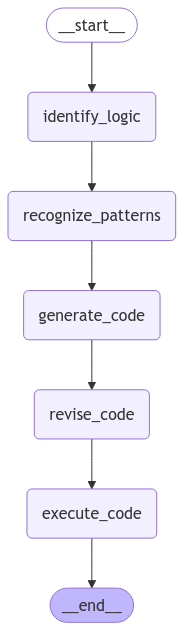

In [15]:
# Import necessary modules
from IPython.display import Image, display

# Adding nodes to the graph for each agent function
graph_builder.add_node("identify_logic", identify_logic)
graph_builder.add_node("recognize_patterns", recognize_patterns)
graph_builder.add_node("generate_code", generate_code)
graph_builder.add_node("revise_code", revise_code)
graph_builder.add_node("execute_code", execute_code)

# Define edges between nodes to establish the flow between agents
graph_builder.add_edge(START, "identify_logic")
graph_builder.add_edge("identify_logic", "recognize_patterns")
graph_builder.add_edge("recognize_patterns", "generate_code")
graph_builder.add_edge("generate_code", "revise_code")
graph_builder.add_edge("revise_code", "execute_code")
graph_builder.add_edge("execute_code", END)

# Compile the graph for execution
graph = graph_builder.compile()

# Display the compiled graph visually
try:
    # Display the graph in Mermaid format with xray view enabled
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception as e:
    print("Error displaying the graph:", e)


### Creating function to get task prediction, make prompt, make API calls to model and parse output with retries

In [16]:
def get_task_prediction(challenge_tasks, solutions, task_id, test_input_index, plot=False):
    task_string = json_task_to_string(challenge_tasks, task_id, test_input_index)
    task_data = challenge_tasks[task_id]
    
    train_tasks = task_data['train']
    train_inputs = [t['input'] for t in train_tasks]
    train_outputs = [t['output'] for t in train_tasks]
    test_input = task_data['test'][test_input_index]['input']
    
    # Ensure you have the actual solution
    actual_solution = solutions.get(task_id, [])[test_input_index]
    
    # Predict the grid size
    predicted_grid_size = predict_task_grid_size(train_inputs, train_outputs, [test_input])[0]

    initial_state = {
        'task_string': task_string,
        'task_data': task_data,
        'test_input_index': test_input_index,
        'predicted_grid_size': predicted_grid_size,
        'messages': [],
        'patterns': [],
        'code': '',
        'revised_code': '',
        'prediction': []
    }

    # Invoke the graph or prediction model
    final_state = graph.invoke(initial_state)
    predicted_solution = final_state.get('prediction', [])

    # Add debugging print statements
    if plot:
        try:
            print("Debug - Plotting dimensions:")
            print(f"Test input shape: {np.array(test_input).shape}")
            print(f"Predicted solution shape: {np.array(predicted_solution).shape}")
            print(f"Actual solution shape: {np.array(actual_solution).shape}")
            
            # Only plot if we have valid arrays
            if len(predicted_solution) > 0:
                logger.info(f"Plotting results for task {task_id}, attempt {test_input_index}")
                plot_eval(task_data, f"Task {task_id} Attempt", test_input, predicted_solution, actual_solution)
            else:
                logger.warning("Skipping plot - predicted solution is empty")
        except Exception as e:
            logger.error(f"Error during plotting: {str(e)}")
            plt.close('all')  # Clean up any partial plots

    # Extract messages and return structured output
    messages = final_state.get('messages', [])
    if messages:
        messages = [msg.content if isinstance(msg, AIMessage) else msg for msg in messages]

    output_details = {
        'messages': messages,
        'patterns': final_state.get('patterns', []),
        'code': final_state.get('code', ''),
        'revised_code': final_state.get('revised_code', ''),
        'prediction': predicted_solution
    }

    return output_details

In [17]:
def make_serializable(obj):
    if isinstance(obj, (AIMessage, HumanMessage)):
        return obj.content
    elif isinstance(obj, list):
        return [make_serializable(item) for item in obj]
    elif isinstance(obj, dict):
        return {key: make_serializable(value) for key, value in obj.items()}
    else:
        return obj  # Assume the object is already serializable

def run_model(challenges, solutions, NUM_ATTEMPTS=2, RETRY_ATTEMPTS=3, NUM_TASKS=None):
    submission = {}
    detailed_outputs = {}

    for i, task_id in enumerate(challenges):
        task_attempts = []
        detailed_outputs[task_id] = []

        # Iterate through each test pair for a prediction
        for t, pair in enumerate(challenges[task_id]['test']):
            logger.info(f"Starting task #{i + 1} ({task_id}), pair #{t+1}")

            # Get the predicted grid size
            train_tasks = challenges[task_id]['train']
            train_inputs = [t['input'] for t in train_tasks]
            train_outputs = [t['output'] for t in train_tasks]
            test_input = challenges[task_id]['test'][t]['input']
            predicted_grid_size = predict_task_grid_size(train_inputs, train_outputs, [test_input])[0]

            pair_attempts = {}
            pair_detailed = {
                'predicted_grid_size': predicted_grid_size  # Add the predicted grid size here
            }

            # Make attempts with retries
            for attempt in range(1, NUM_ATTEMPTS + 1):
                attempt_key = f"attempt_{attempt}"
                pair_attempts[attempt_key] = []
                pair_detailed[attempt_key] = {
                    'predicted_grid_size': predicted_grid_size  # Add it to each attempt as well
                }

                # Run retries within the attempt
                for retry in range(RETRY_ATTEMPTS):
                    # Always plot in notebook
                    should_plot = True
                    logger.info(f"Plot flag for task {task_id}, attempt {attempt}, retry {retry}: {should_plot}")

                    try:
                        prediction_details = get_task_prediction(
                            challenge_tasks=challenges,
                            solutions=solutions,
                            task_id=task_id,
                            test_input_index=t,
                            plot=should_plot
                        )

                        # Print prediction details for debugging
                        print(f"\nPrediction details for {attempt_key}, retry {retry}:")
                        print(f"Prediction: {prediction_details['prediction']}")
                        print(f"Expected solution: {solutions[task_id][t]}")

                        # Store valid prediction and exit retry loop on success
                        if prediction_details['prediction']:  # Only store if we have a prediction
                            pair_attempts[attempt_key] = prediction_details['prediction']
                            pair_detailed[attempt_key] = prediction_details
                            
                            # Check if prediction matches solution
                            if prediction_details['prediction'] == solutions[task_id][t]:
                                print(f"Found correct solution in {attempt_key}, retry {retry}")
                                break
                            
                        break  # Exit retry loop if we got any valid prediction
                    except Exception as e:
                        logger.warning(f"Retrying: {e}")
                        if retry == RETRY_ATTEMPTS - 1:
                            pair_attempts[attempt_key] = []
                            pair_detailed[attempt_key] = {'error': str(e)}

            task_attempts.append(pair_attempts)
            detailed_outputs[task_id].append(pair_detailed)

        submission[task_id] = task_attempts

        if NUM_TASKS is not None and i + 1 == NUM_TASKS:
            break

    # Save detailed outputs
    serializable_outputs = make_serializable(detailed_outputs)
    with open('detailed_outputs.json', 'w') as f:
        json.dump(serializable_outputs, f, indent=2)

    return submission

### Creating submission files and comparing it with solutions file

In [18]:
# create submission file
def create_submission_file(submission, file_name='submission.json'):
    """
    Save a submission file to the specified file name
    """
    with open(file_name, "w") as file:
        json.dump(submission, file)

    print (f"Submission saved to {file_name}")

In [19]:
# Create function to compare submission with solutions
def score_submission(submission_file_name, solutions) -> Tuple[float, int]:
    """
    submission_file_name: str, the file name of your submission file
    solutions: dict, the ground truth solutions you'd like to test against
    """
    print(f"Scoring {submission_file_name}\n")

    # Open your submission file
    with open(submission_file_name, "r") as file:
        submission = json.load(file)

    # Filter solutions to include only tasks in the submission
    filtered_solutions = {task_id: solutions[task_id] for task_id in submission if task_id in solutions}

    total_score = 0
    total_tasks = 0

    # Add debugging prints
    #print("Solutions contents:")
    #print(json.dumps(filtered_solutions, indent=2))

    # Loop through each task in your submission to grade it
    for task_id, task_submission in submission.items():
        if task_id not in filtered_solutions:
            print(f"Task {task_id} not found in solutions, skipping.")
            continue

        total_tasks += 1
        task_score = 0
        num_pairs = len(task_submission)

        print(f"\nScoring task {task_id}:")
        print(f"Number of test pairs: {num_pairs}")

        # Go through each task. Most will only have 1
        for pair_index, pair_attempts in enumerate(task_submission):
            print(f"\nScoring Task {task_id} pair #{pair_index+1}")
            print(f"Attempts available: {list(pair_attempts.keys())}")
            pair_correct = False

            # Look at both of your attempts
            for attempt_key, attempt in pair_attempts.items():
                print(f"\nChecking {attempt_key}:")
                print(f"Attempt solution: {attempt}")
                print(f"Correct solution: {filtered_solutions[task_id][pair_index]}")
                
                # check to see if one is correct
                if attempt == filtered_solutions[task_id][pair_index]:
                    print(f"Task Id {task_id} pair {pair_index+1} {attempt_key} matches solution")
                    pair_correct = True
                    break # If it is correct, log it and break the loop

            if pair_correct:
                task_score += 1
                print(f"Pair {pair_index+1} is correct")
            else:
                print(f"Pair {pair_index+1} is incorrect")

        task_score /= num_pairs
        total_score += task_score
        print(f"\nTask {task_id} score: {task_score}")

    final_score = {
        'total_score': total_score,
        'total_tasks_scored': total_tasks,
        'percentage': round(total_score / total_tasks * 100, 2) if total_tasks > 0 else 0
    }
    
    print(f"\nFinal scoring results:")
    print(f"Total score: {final_score['total_score']}")
    print(f"Total tasks: {final_score['total_tasks_scored']}")
    print(f"Percentage: {final_score['percentage']}%")

    return final_score


#### The main function to bring everything together

In [20]:
def main(task_set='training', NUM_TASKS=None, submission_file_name='submission.json'):
    # Load datasets
    challenges, solutions = load_tasks_from_file(task_set=task_sets[task_set])

    # Run the model, passing both challenges and solutions
    submission = run_model(challenges, solutions, NUM_TASKS=NUM_TASKS)

    # Create (and overwrite) a submission file
    create_submission_file(submission, file_name=submission_file_name)

    # Score the submission
    score_result = score_submission(submission_file_name=submission_file_name, solutions=solutions)

    logger.info(f"Final score: {score_result['total_score']} of {score_result['total_tasks_scored']} ({round(score_result['total_score'] / score_result['total_tasks_scored'] * 100, 2)}%)")

    # Optionally, load and display detailed outputs
    try:
        with open('detailed_outputs.json', 'r') as f:
            detailed_outputs = json.load(f)
        # For example, print the detailed outputs
        # print(json.dumps(detailed_outputs, indent=2))
    except Exception as e:
        logger.error(f"Error loading detailed outputs: {e}")


# RUNNING THE MODEL

2025-01-05 14:05:40,125 - INFO - Starting task #1 (00576224), pair #1
2025-01-05 14:05:40,126 - INFO - Plot flag for task 00576224, attempt 1, retry 0: True
Debug - Plotting dimensions:
Test input shape: (2, 2)
Predicted solution shape: (6, 6)
Actual solution shape: (6, 6)
2025-01-05 14:05:53,796 - INFO - Plotting results for task 00576224, attempt 0


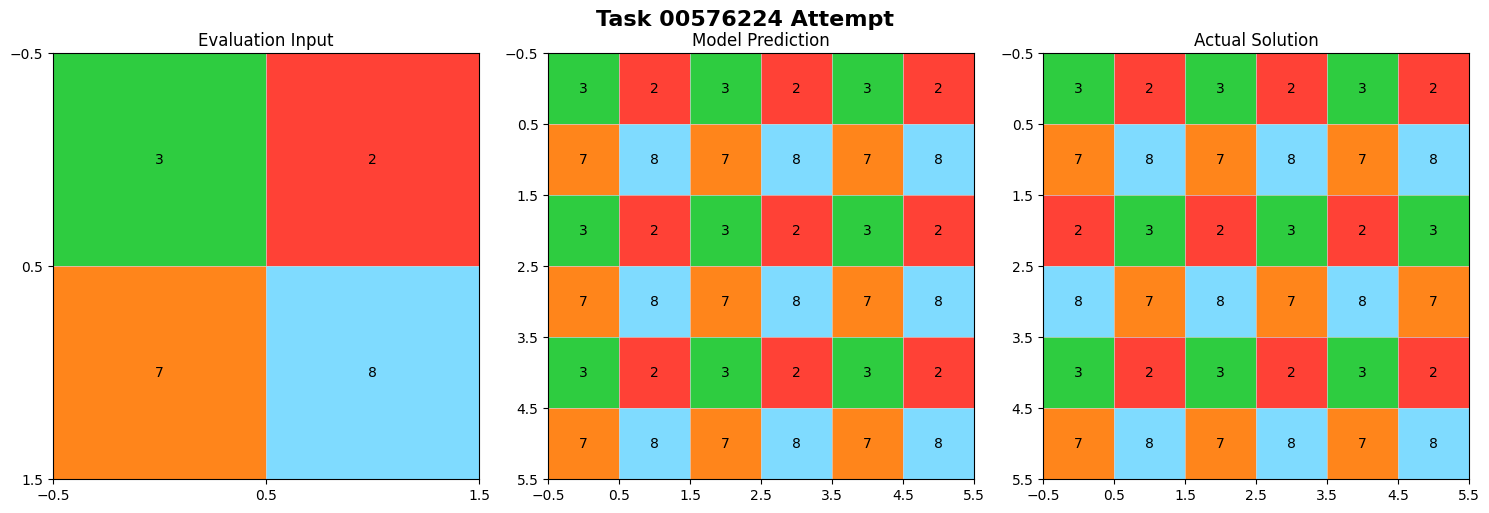


Prediction details for attempt_1, retry 0:
Prediction: [[3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8], [3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8], [3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8]]
Expected solution: [[3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8], [2, 3, 2, 3, 2, 3], [8, 7, 8, 7, 8, 7], [3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8]]
2025-01-05 14:05:54,461 - INFO - Plot flag for task 00576224, attempt 2, retry 0: True
Debug - Plotting dimensions:
Test input shape: (2, 2)
Predicted solution shape: (6, 6)
Actual solution shape: (6, 6)
2025-01-05 14:06:07,141 - INFO - Plotting results for task 00576224, attempt 0


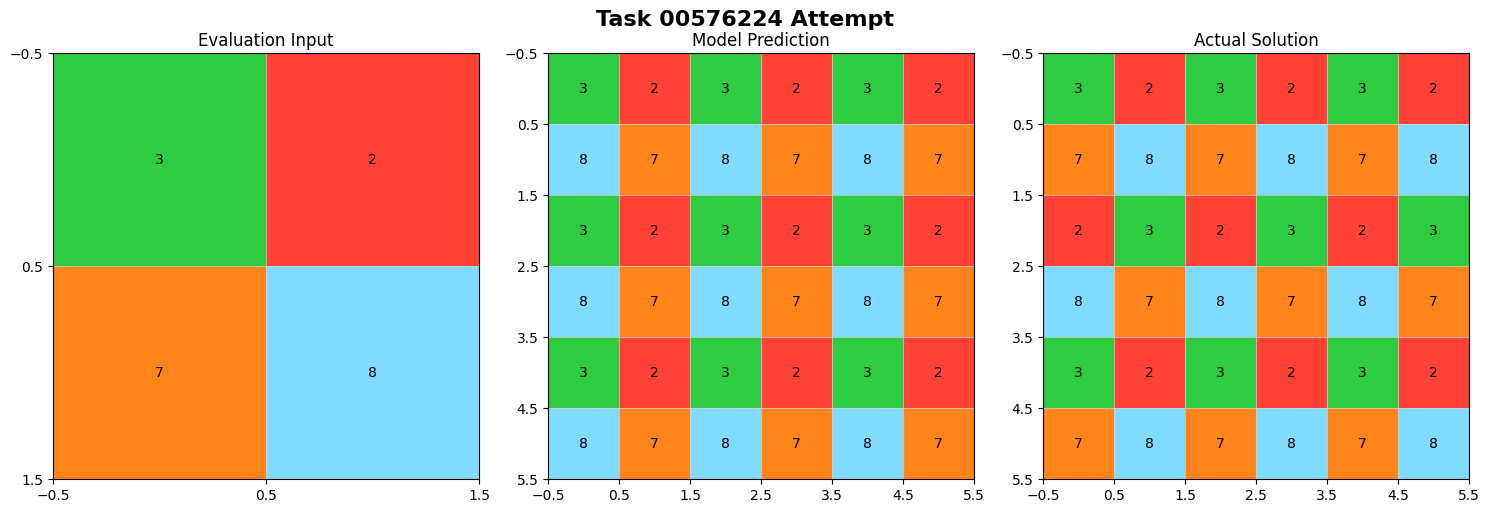


Prediction details for attempt_2, retry 0:
Prediction: [[3, 2, 3, 2, 3, 2], [8, 7, 8, 7, 8, 7], [3, 2, 3, 2, 3, 2], [8, 7, 8, 7, 8, 7], [3, 2, 3, 2, 3, 2], [8, 7, 8, 7, 8, 7]]
Expected solution: [[3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8], [2, 3, 2, 3, 2, 3], [8, 7, 8, 7, 8, 7], [3, 2, 3, 2, 3, 2], [7, 8, 7, 8, 7, 8]]
2025-01-05 14:06:07,664 - INFO - Starting task #2 (17cae0c1), pair #1
2025-01-05 14:06:07,665 - INFO - Plot flag for task 17cae0c1, attempt 1, retry 0: True
Debug - Plotting dimensions:
Test input shape: (3, 9)
Predicted solution shape: (3, 9)
Actual solution shape: (3, 9)
2025-01-05 14:06:28,636 - INFO - Plotting results for task 17cae0c1, attempt 0


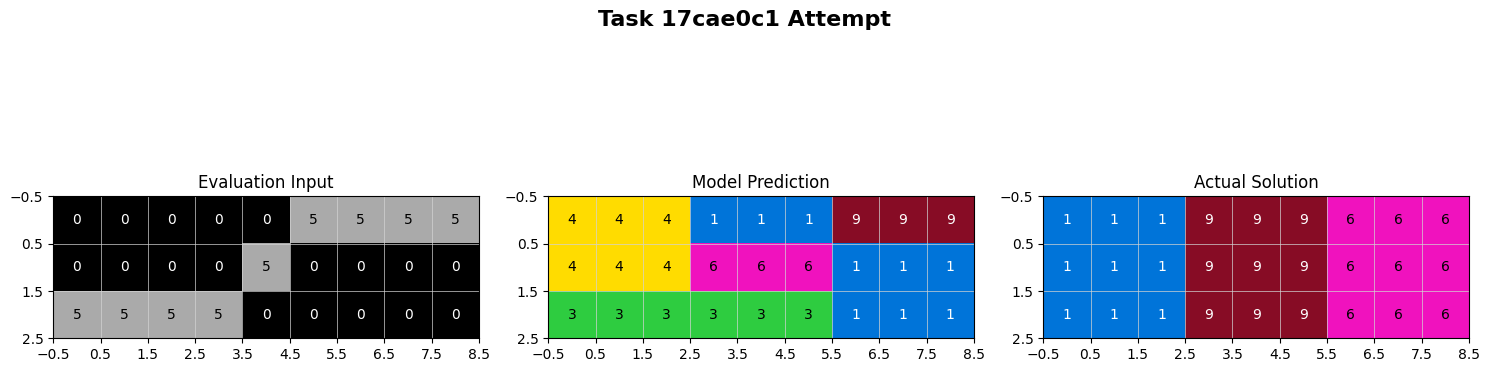


Prediction details for attempt_1, retry 0:
Prediction: [[4, 4, 4, 1, 1, 1, 9, 9, 9], [4, 4, 4, 6, 6, 6, 1, 1, 1], [3, 3, 3, 3, 3, 3, 1, 1, 1]]
Expected solution: [[1, 1, 1, 9, 9, 9, 6, 6, 6], [1, 1, 1, 9, 9, 9, 6, 6, 6], [1, 1, 1, 9, 9, 9, 6, 6, 6]]
2025-01-05 14:06:29,123 - INFO - Plot flag for task 17cae0c1, attempt 2, retry 0: True
Debug - Plotting dimensions:
Test input shape: (3, 9)
Predicted solution shape: (3, 9)
Actual solution shape: (3, 9)
2025-01-05 14:06:45,731 - INFO - Plotting results for task 17cae0c1, attempt 0


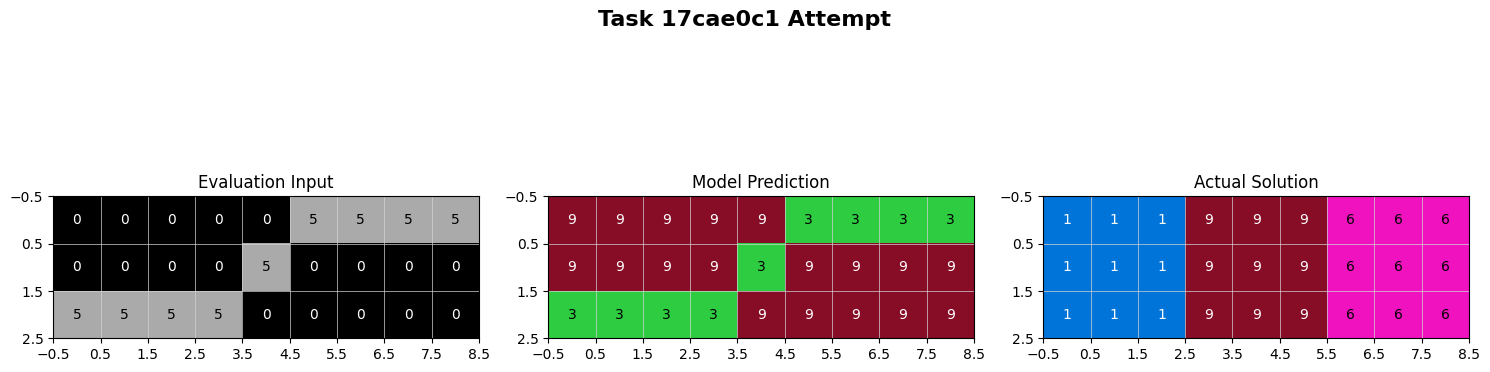


Prediction details for attempt_2, retry 0:
Prediction: [[9, 9, 9, 9, 9, 3, 3, 3, 3], [9, 9, 9, 9, 3, 9, 9, 9, 9], [3, 3, 3, 3, 9, 9, 9, 9, 9]]
Expected solution: [[1, 1, 1, 9, 9, 9, 6, 6, 6], [1, 1, 1, 9, 9, 9, 6, 6, 6], [1, 1, 1, 9, 9, 9, 6, 6, 6]]
2025-01-05 14:06:46,210 - INFO - Starting task #3 (2072aba6), pair #1
2025-01-05 14:06:46,211 - INFO - Plot flag for task 2072aba6, attempt 1, retry 0: True
Debug - Plotting dimensions:
Test input shape: (3, 3)
Predicted solution shape: (6, 6)
Actual solution shape: (6, 6)
2025-01-05 14:07:03,201 - INFO - Plotting results for task 2072aba6, attempt 0


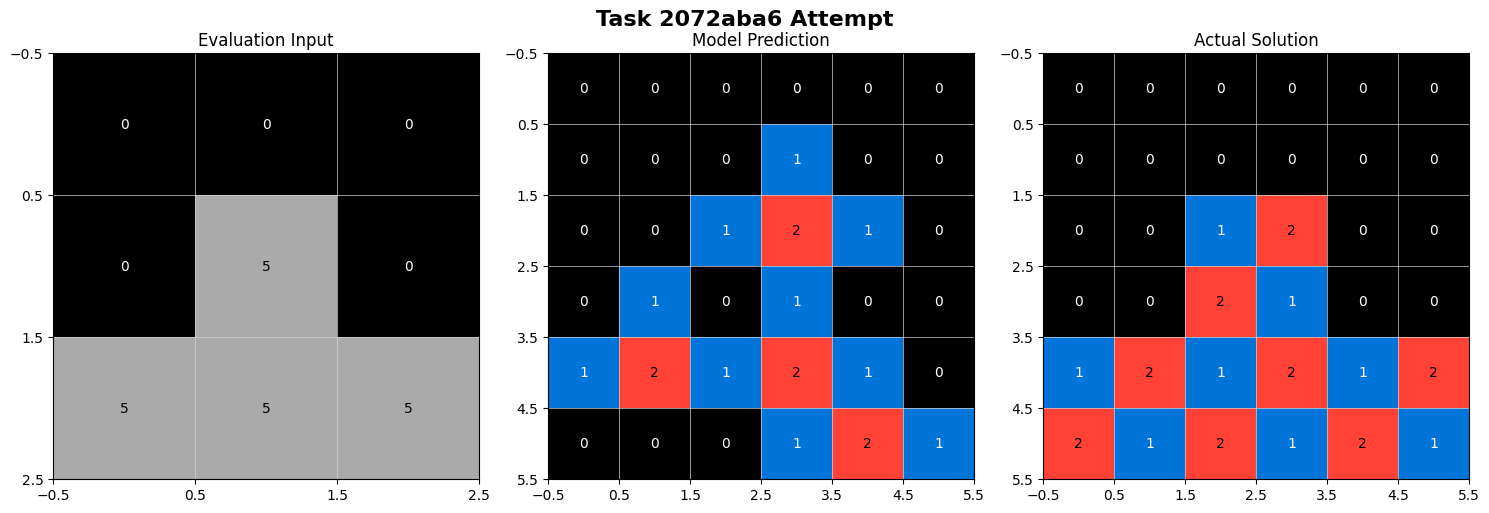


Prediction details for attempt_1, retry 0:
Prediction: [[0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0], [0, 0, 1, 2, 1, 0], [0, 1, 0, 1, 0, 0], [1, 2, 1, 2, 1, 0], [0, 0, 0, 1, 2, 1]]
Expected solution: [[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 1, 2, 0, 0], [0, 0, 2, 1, 0, 0], [1, 2, 1, 2, 1, 2], [2, 1, 2, 1, 2, 1]]
2025-01-05 14:07:03,702 - INFO - Plot flag for task 2072aba6, attempt 2, retry 0: True


KeyboardInterrupt: 

In [21]:
main(task_set='evaluation', NUM_TASKS=3)